## **Import Libraries**

In [59]:
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten , BatchNormalization


from tensorflow.keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns # for confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import json
import os
import numpy as np
import h5py

## **Load Dataset**

In [60]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [61]:
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


## **Visualization**

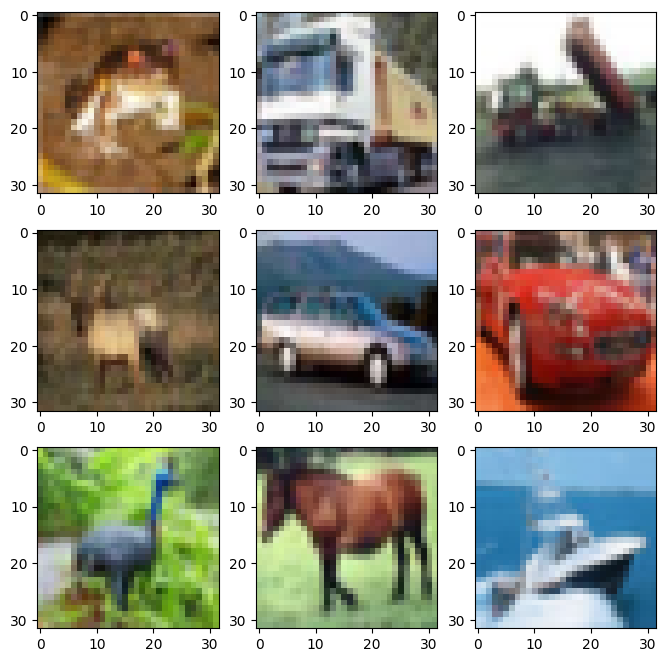

In [62]:
# create a grid of 3x3 images
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = x_train[i]
    plt.imshow(img)
    
# show the plot
plt.show()

## **Preprocess and Splitting**

In [63]:
def normalize(x):
    x = x.astype('float32')
    x = x/255.0
    return x

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
)

### Split Data

In [64]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0) # seed for fixing the x_test and y_test

In [65]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

y_train = tf.keras.utils.to_categorical(y_train , 10) # one hot encoding
y_test = tf.keras.utils.to_categorical(y_test , 10)
y_val  = tf.keras.utils.to_categorical(y_val , 10)

datagen.fit(x_train)

In [66]:
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(5000, 10)
(5000, 10)


## **Model**

In [67]:
teacher = load_model("../NoteBook/Teacher/Teacher-2/model.h5")

In [68]:
division_factor = 4
weight_decay = 1e-4
student = Sequential([
    Conv2D(64//division_factor, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(64//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(128//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(256//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10)
])

student.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 338,970 (1.29 MB)

 Trainable params: 338,010 (1.29 MB)

 Non-trainable params: 960 (3.75 KB)

### Training

#### Distiller Class

In [69]:
class Distiller(tf.keras.Model):
    def __init__(self,student,teacher,temperature=10,alpha=0.7,**args):
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.distillation_loss_fn = tf.keras.losses.KLDivergence()
        super().__init__(**args)

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self.student(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            student_loss = self.compute_loss(y=y, y_pred=y_pred)

            y_pred_teacher = self.teacher(x,training=False) 
            distillation_loss = self.distillation_loss_fn(
            tf.keras.ops.softmax(y_pred_teacher / self.temperature, axis=1),
            tf.keras.ops.softmax(y_pred / self.temperature, axis=1),
            ) * (self.temperature**2)

            loss = self.alpha*student_loss  + (1- self.alpha)*distillation_loss

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
        
    def test_step(self, data):
        x, y = data
        y_pred = self.student(x, training=False)
        student_loss = self.compute_loss(y=y, y_pred=y_pred)

        y_pred_teacher = self.teacher(x,training=False) 
        distillation_loss = self.distillation_loss_fn(
            tf.keras.ops.softmax(y_pred_teacher / self.temperature, axis=1),
            tf.keras.ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha*student_loss  + (1- self.alpha)*distillation_loss

        for metric in self.metrics:
            if metric.name == "val_loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    def call(self,x):
        return self.student(x)

In [70]:
opt =    tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
distiller = Distiller(teacher, student,alpha=0.80)

distiller.compile(
    opt,
    metrics=['accuracy'],
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    )


In [71]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', 
                                patience=10,
                                cooldown=1,
                                verbose=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=15)]

In [72]:
epoch  = 50
history = distiller.fit(datagen.flow(x_train , y_train , batch_size = 64), epochs = epoch, steps_per_epoch=len(x_train)//64, validation_data = (x_val , y_val) , verbose = 1)

Epoch 1/50


781/781 ━━━━━━━━━━━━━━━━━━━━ 345s 428ms/step - accuracy: 0.8506 - loss: 0.9858 - val_accuracy: 0.8422 - val_loss: 1.3877
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8438 - loss: 0.3838 - val_accuracy: 0.8450 - val_loss: 1.3697
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 321s 411ms/step - accuracy: 0.8500 - loss: 0.7379 - val_accuracy: 0.8464 - val_loss: 2.1040
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8594 - loss: 0.3812 - val_accuracy: 0.8494 - val_loss: 2.1158
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 357s 457ms/step - accuracy: 0.8445 - loss: 0.7205 - val_accuracy: 0.8260 - val_loss: 2.6599
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8594 - loss: 0.3150 - val_accuracy: 0.8310 - val_loss: 2.7560
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 321s 410ms/step - accuracy: 0.8464 - loss: 0.6992 - val_accuracy: 0.8598 - val_loss: 2.7402
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9062 - loss: 0.3166 - val_ac

## **Results and Save**

### **Results**

In [82]:
def plot_results(model):
    epoch = max(
        [
            len(history.history[key]) for key in ["accuracy","val_accuracy","loss","val_loss"]
        ]
        )
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Classification Accuracy")
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Model loss")
    plt.show()

In [83]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Args:
    y_true (list or array): True labels.
    y_pred (list or array): Predicted labels.
    classes (list): List of class names for labeling the axes in the plot.
    cmap (matplotlib.colors.Colormap, optional): Colormap to be used for the plot. Defaults to plt.cm.Blues.
    
    Returns:
    None: Displays the confusion matrix.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate model performance metrics including accuracy, precision, recall, and F1 score.
    
    Args:
    y_true (list or array): Actual true labels.
    y_pred (list or array): Predicted labels from the model.
    
    Returns:
    dict: A dictionary containing all the scores.
    """
    scores = {}
    scores['accuracy'] = accuracy_score(y_true, y_pred)
    scores['precision'] = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for unweighted mean
    scores['recall'] = recall_score(y_true, y_pred, average='macro')
    scores['f1_score'] = f1_score(y_true, y_pred, average='macro')
    
    return scores

In [84]:
acc = distiller.student.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)


# model2 = load_model("Teacher-1/model.h5")
# acc = model2.evaluate(x_test , y_test)


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8659 - loss: 0.6463
test set loss :  0.6394793391227722
test set accuracy : 86.97999715805054


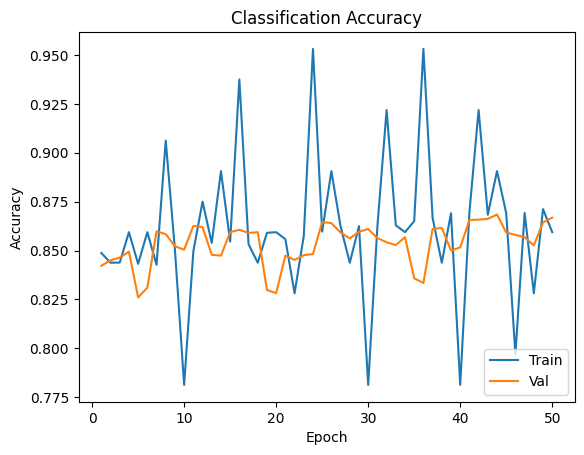

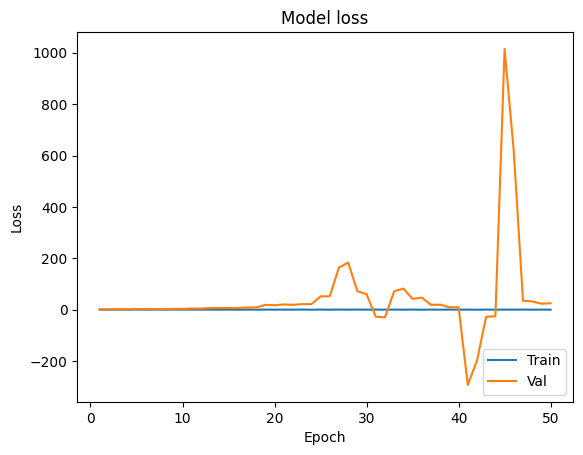

In [85]:
plot_results(distiller)

### Confusion Matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


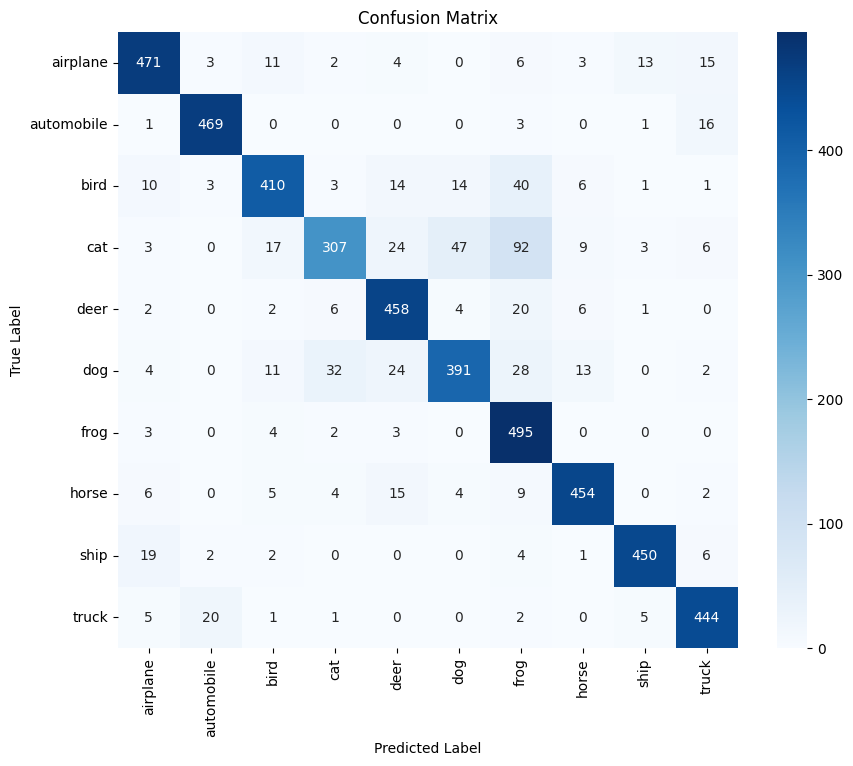

In [86]:
# Make predictions
y_pred = distiller.predict(x_test)
# Convert predictions from probabilities to labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)
# Assuming y_test is also in a one-hot encoded format, convert it to labels
y_true_labels = np.argmax(y_test, axis=1)


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
conf_matrix = plot_confusion_matrix(y_true_labels, y_pred_labels,class_names)


### Other Scores

In [87]:
# Evaluate other performance metrics
performance_scores = evaluate_model_performance(y_true_labels, y_pred_labels)
print("Performance Scores:")
for score_name, score_value in performance_scores.items():
    print(f"{score_name.capitalize()}: {score_value}")

Performance Scores:
Accuracy: 0.8698
Precision: 0.8765733366183855
Recall: 0.8707118544392107
F1_score: 0.868770809800394


### Save

In [88]:
from random import randint
def saveModel(model, history: dict, dir_prefix: str = r"..\NoteBook\DistilledStudent", dir_output:str=r"DistilledStudent-1"):
    """
    Creates a directory and saves the model in .h5 format, training history as a JSON file,
    and training and test datasets as .npy files.

    Args:
    model (tf.keras.Model): The trained Keras model to save.
    history (dict): Dictionary containing the training history.
    x_test, y_test, x_train, y_train (numpy.ndarray): Datasets to save.
    output_dir (str, optional): The directory to save all files. Defaults to "TeacherModel".

    Returns:
    bool: True if all files are saved successfully, False if an error occurs.
    """
    try:        
    # Create the directory if it does not exist
        dir_path = os.path.join(dir_prefix, dir_output)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
        history_path = os.path.join(dir_path, "history.json")
        with open(history_path, 'w') as f:
            f.write(json.dumps(history,indent=4))
            f.close()

        model_path = os.path.join(dir_path, "model.keras")
        model.save(model_path)
        

        return True
    except Exception as e:
        print(type(e))
        print(f"An error occurred: {e}")
        
        return False


In [89]:
index = 100
print(saveModel(distiller,history.history,dir_output=f"DistilledStudent-{index}"))

True
